# Setup

In [73]:
import pdb
import sys

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer

In [22]:
%reload_ext autoreload
%autoreload 2

src_path = "/Users/aarontrefler_temp2/Documents/My Documents/Kaggle/ncaa-men-19/src"
sys.path.insert(0, src_path)

import data
import features as feat

from utils import cols_to_front, display_df

pd.options.display.max_columns = 999

In [23]:
data_raw_dir = '../data/raw/'
data_clean_dir = '../data/clean/'

# Read and Process Data Files

In [39]:
# Read and process teams
df_teams = (
    pd.read_csv(data_raw_dir + 'DataFiles/Teams.csv')
    .pipe(data.process_teams)
)

# Read and process seeds
df_seeds = (
    pd.read_csv(data_raw_dir + 'DataFiles/NCAATourneySeeds.csv')
    .pipe(data.process_seeds)
)

# Read and process regular season detailed results
df_rs_d_res = (
    pd.read_csv(data_raw_dir + 'DataFiles/RegularSeasonDetailedResults.csv')
    .pipe(data.process_regular_season_detailed_results)
    .pipe(feat.create_advanced_statistics)
)

# Read and process tournament games
df_games = (
    pd.read_csv(data_raw_dir + 'DataFiles/NCAATourneyCompactResults.csv')
    .pipe(data.process_games)
)

# Read and process tournament games submission file
df_sub = (
    pd.read_csv(data_raw_dir + 'SampleSubmissionStage1.csv')
    .pipe(data.process_submission_games)
)

In [40]:
display_df(df_teams, title="Teams")
display_df(df_seeds, title="Seeds")
display_df(df_games, title="Games")
display_df(df_sub, title="SubmissionGames")
display_df(df_rs_d_res, title="Regular Season Detailed Results")

Teams:


,TeamID,TeamName
0,1101,Abilene Chr


(366, 2)

Seeds:


,Season,Seed,TeamID,IsPlayIn
0,1985,1,1207,False


(2218, 4)

Games:


,Season,Label,TeamOneID,TeamTwoID
0,1985,1,1116,1234


(2184, 4)

SubmissionGames:


,Season,TeamOneID,TeamTwoID
0,2014,1107,1110


(11390, 3)

Regular Season Detailed Results:


,Ast,Ast_opp,Blk,Blk_opp,DR,DR_opp,DayNum,FGA,FGA3,FGA3_opp,FGA_opp,FGM,FGM3,FGM3_opp,FGM_opp,FTA,FTA_opp,FTM,FTM_opp,Loc,Loc_opp,NumOT,OR,OR_opp,PF,PF_opp,Score,Score_opp,Season,Stl,Stl_opp,TO,TO_opp,TeamID,TeamID_opp,Poss,Poss_opp,OffRating,DefRating,NetRating,Pace
0,13,8,1,2,24,22,10,58,14,10,53,27,3,2,22,18,22,11,16,N,NaN,0,14,10,22,20,68,62,2003,7,9,23,18,1104,1328,75.55,71.45,90.006618,86.773968,3.23265,73.5


(164082, 41)

# Aggregate Data

In [41]:
df_rs_d_res_agg = (
    df_rs_d_res_adv
    .groupby(['TeamID', 'Season'])
    .mean()
    .drop(['TeamID_opp', 'DayNum'], axis=1)
    .reset_index()
)

In [42]:
display_df(df_rs_d_res_agg, title="Average Regular Season Detailed Results")

Average Regular Season Detailed Results:


,TeamID,Season,Ast,Ast_opp,Blk,Blk_opp,DR,DR_opp,FGA,FGA3,FGA3_opp,FGA_opp,FGM,FGM3,FGM3_opp,FGM_opp,FTA,FTA_opp,FTM,FTM_opp,NumOT,OR,OR_opp,PF,PF_opp,Score,Score_opp,Stl,Stl_opp,TO,TO_opp,Poss,Poss_opp,OffRating,DefRating,NetRating,Pace
0,1101,2014,10.0,15.571429,1.47619,5.0,20.333333,24.095238,50.142857,17.857143,16.190476,53.428571,20.333333,6.666667,6.0,27.142857,21.190476,25.809524,15.809524,18.333333,0.142857,8.0,10.380952,21.571429,18.666667,63.142857,78.619048,5.761905,7.0,15.0,12.142857,67.208333,67.45,93.486373,116.657445,-23.171072,67.329167


(5481, 37)

# Merge Datasets

In [60]:
# Merge tournament games with datasets
df_interim_mdl = (
    df_games
    .pipe(data.merge_seed_dataset, df_seeds=df_seeds, submission_file=False)
    .pipe(data.merge_aggregated_regular_season_detailed_results, df_rs_d_res_agg=df_rs_d_res_agg)
    .sort_values(['Season', 'TeamOneID'])
)

# Merge submission file games with datasets
df_interim_sub = (
    df_sub
    .pipe(data.merge_seed_dataset, df_seeds=df_seeds, submission_file=True)
    .pipe(data.merge_aggregated_regular_season_detailed_results, df_rs_d_res_agg=df_rs_d_res_agg)
    .sort_values(['Season', 'TeamOneID'])
)

In [61]:
display_df(df_interim_mdl.sort_values(['Season', 'TeamOneID']), tail=True)
display_df(df_interim_sub, n=1)

,Season,Label,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace
37,1985,1,1104,1112,7,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Season,Label,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace
2132,2018,1,1437,1452,1,5,16.676471,14.0,3.970588,2.676471,26.205882,23.147059,61.529412,28.676471,21.352941,60.205882,31.029412,11.411765,7.0,26.147059,17.617647,15.382353,13.588235,11.588235,0.088235,9.382353,9.558824,15.852941,17.235294,87.058824,70.882353,6.676471,4.558824,10.352941,13.117647,70.868382,71.071324,122.9814,99.758537,23.222863,70.969853,15.058824,12.235294,5.264706,3.941176,23.882353,24.235294,64.0,24.911765,20.147059,52.970588,27.764706,8.794118,7.529412,22.5,19.970588,23.382353,15.294118,16.470588,0.029412,14.0,10.235294,21.382353,18.764706,79.617647,69.0,8.029412,5.470588,11.323529,16.5,70.809559,70.341912,112.591216,98.798682,13.792534,70.575735


(2142, 76)

,Season,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace
0,2014,1107,1110,16,15,11.0625,12.34375,3.0625,3.03125,24.21875,21.59375,51.09375,13.46875,19.59375,54.34375,22.4375,4.90625,6.90625,22.75,21.71875,15.84375,16.25,11.4375,0.09375,10.34375,9.9375,17.25,19.25,66.03125,63.84375,5.53125,5.84375,12.625,11.96875,63.691406,63.900781,103.790983,100.032247,3.758736,63.796094,15.125,10.09375,3.4375,2.4375,22.9375,19.3125,46.5625,16.59375,15.0625,49.03125,23.03125,6.34375,4.71875,20.15625,16.25,20.1875,11.53125,13.59375,0.03125,7.125,9.78125,17.21875,17.625,63.9375,58.625,6.03125,7.03125,13.96875,12.125,61.125,60.964063,104.874508,96.637013,8.237495,61.044531


(11390, 75)

# Analyze Missing Data

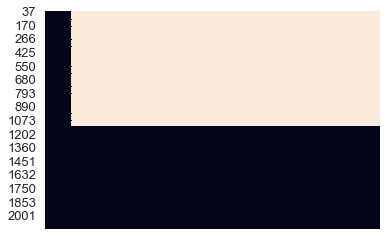

Regular season data available from 2003 onward


In [82]:
sns.heatmap(df_interim_mdl.isnull(), cbar=False, xticklabels=False)
plt.show()
print("Regular season data available from 2003 onward")

# Create Features

In [94]:
def impute_missing_values(df, imputer):
    return pd.DataFrame(imputer.fit_transform(df.values), columns=df.columns)


# Create features for modeling dataset
df_clean_mdl = (
    df_interim_mdl
    .pipe(feat.create_diff_feats)
    .pipe(impute_missing_values, imputer=SimpleImputer(missing_values=np.nan, strategy='median'))
)

# Create features for submission dataset
df_clean_sub = (
    df_interim_sub
    .pipe(feat.create_diff_feats)
    .pipe(impute_missing_values, imputer=SimpleImputer(missing_values=np.nan, strategy='median'))  # no missing data, performed for float conversion consistencty
)

In [95]:
display_df(df_clean_mdl, n=1, tail=True, title="Games")
display_df(df_clean_sub, n=1, title="Submission Games")

Games:


,Season,Label,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
0,1985.0,1.0,1104.0,1112.0,7.0,10.0,14.774194,11.939394,4.0,3.135632,24.8,21.863971,56.716578,18.741935,18.727273,56.298574,26.412121,6.864368,6.151515,23.096774,21.571429,18.439338,15.298574,12.612903,0.058824,11.65625,11.112395,17.636364,19.063508,74.911765,65.272727,6.9375,5.970588,12.777722,13.875,67.914504,67.954839,110.166058,96.550243,13.424874,67.951788,14.537054,11.934409,3.823529,3.137931,24.790998,22.140394,56.867965,18.758098,18.587198,55.8125,25.969697,6.8,6.107143,22.891176,21.368519,18.5,15.149287,12.666667,0.057143,11.735294,10.909091,17.550056,19.16129,73.809091,65.129032,6.882353,6.014706,12.545455,13.88057,67.701591,67.659652,109.385849,95.974371,13.78543,67.667773,0.148522,0.006061,0.102083,0.017793,0.142525,-0.092708,0.210446,0.621473,-0.124777,-0.065236,0.364468,0.298574,0.061581,0.001927,0.319073,0.036706,0.266544,-0.010959,-0.018939,0.266043,0.109927,0.053883,0.959197,0.494656,0.097232,0.134241,0.192761,0.03457,0.406157,0.417045,-3.0,0.0,0.490111,0.153702,0.050672,0.344328


,Season,Label,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
2141,2018.0,1.0,1437.0,1452.0,1.0,5.0,16.676471,14.0,3.970588,2.676471,26.205882,23.147059,61.529412,28.676471,21.352941,60.205882,31.029412,11.411765,7.0,26.147059,17.617647,15.382353,13.588235,11.588235,0.088235,9.382353,9.558824,15.852941,17.235294,87.058824,70.882353,6.676471,4.558824,10.352941,13.117647,70.868382,71.071324,122.9814,99.758537,23.222863,70.969853,15.058824,12.235294,5.264706,3.941176,23.882353,24.235294,64.0,24.911765,20.147059,52.970588,27.764706,8.794118,7.529412,22.5,19.970588,23.382353,15.294118,16.470588,0.029412,14.0,10.235294,21.382353,18.764706,79.617647,69.0,8.029412,5.470588,11.323529,16.5,70.809559,70.341912,112.591216,98.798682,13.792534,70.575735,1.617647,1.764706,-1.294118,-1.264706,2.323529,-1.088235,-2.470588,7.235294,3.764706,1.205882,3.264706,3.647059,2.617647,-0.529412,-2.352941,-8.0,-1.705882,-4.882353,-4.617647,-0.676471,-5.529412,-1.529412,7.441176,1.882353,-1.352941,-0.911765,-0.970588,-3.382353,0.058824,0.729412,-4.0,0.058824,10.390184,0.959855,9.430329,0.394118


(2142, 112)

Submission Games:


,Season,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
0,2014.0,1107.0,1110.0,16.0,15.0,11.0625,12.34375,3.0625,3.03125,24.21875,21.59375,51.09375,13.46875,19.59375,54.34375,22.4375,4.90625,6.90625,22.75,21.71875,15.84375,16.25,11.4375,0.09375,10.34375,9.9375,17.25,19.25,66.03125,63.84375,5.53125,5.84375,12.625,11.96875,63.691406,63.900781,103.790983,100.032247,3.758736,63.796094,15.125,10.09375,3.4375,2.4375,22.9375,19.3125,46.5625,16.59375,15.0625,49.03125,23.03125,6.34375,4.71875,20.15625,16.25,20.1875,11.53125,13.59375,0.03125,7.125,9.78125,17.21875,17.625,63.9375,58.625,6.03125,7.03125,13.96875,12.125,61.125,60.964063,104.874508,96.637013,8.237495,61.044531,-4.0625,2.25,-0.375,0.59375,1.28125,2.28125,4.53125,5.3125,-3.125,4.53125,-0.59375,2.59375,-1.4375,2.1875,5.46875,-4.34375,4.71875,-2.15625,3.21875,0.15625,0.03125,1.625,2.09375,5.21875,-0.5,-1.1875,-1.34375,-0.15625,2.566406,2.936719,1.0,0.0625,-1.083525,3.395235,-4.47876,2.751562


(11390, 111)

# Save datasets

In [96]:
df_clean_mdl_save = (
    df_clean_mdl
    .pipe(data.merge_team_dataset, df_teams=df_teams)
    .sort_values(['Season', 'TeamOneID'])
    .pipe(cols_to_front, front_cols=['Season', 'TeamOne_Name', 'TeamTwo_Name'])
)

df_clean_sub_save = (
    df_clean_sub
    .pipe(data.merge_team_dataset, df_teams=df_teams)
    .sort_values(['Season', 'TeamOneID'])
    .pipe(cols_to_front, front_cols=['Season', 'TeamOne_Name', 'TeamTwo_Name'])
)

In [97]:
display_df(df_clean_mdl, n=5, tail=True)
display_df(df_clean_sub, n=1, title="Submission Games")

,Season,Label,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
0,1985.0,1.0,1104.0,1112.0,7.0,10.0,14.774194,11.939394,4.0,3.135632,24.8,21.863971,56.716578,18.741935,18.727273,56.298574,26.412121,6.864368,6.151515,23.096774,21.571429,18.439338,15.298574,12.612903,0.058824,11.65625,11.112395,17.636364,19.063508,74.911765,65.272727,6.9375,5.970588,12.777722,13.875,67.914504,67.954839,110.166058,96.550243,13.424874,67.951788,14.537054,11.934409,3.823529,3.137931,24.790998,22.140394,56.867965,18.758098,18.587198,55.8125,25.969697,6.8,6.107143,22.891176,21.368519,18.5,15.149287,12.666667,0.057143,11.735294,10.909091,17.550056,19.16129,73.809091,65.129032,6.882353,6.014706,12.545455,13.88057,67.701591,67.659652,109.385849,95.974371,13.78543,67.667773,0.148522,0.006061,0.102083,0.017793,0.142525,-0.092708,0.210446,0.621473,-0.124777,-0.065236,0.364468,0.298574,0.061581,0.001927,0.319073,0.036706,0.266544,-0.010959,-0.018939,0.266043,0.109927,0.053883,0.959197,0.494656,0.097232,0.134241,0.192761,0.03457,0.406157,0.417045,-3.0,0.0,0.490111,0.153702,0.050672,0.344328
1,1985.0,1.0,1104.0,1433.0,7.0,2.0,14.774194,11.939394,4.0,3.135632,24.8,21.863971,56.716578,18.741935,18.727273,56.298574,26.412121,6.864368,6.151515,23.096774,21.571429,18.439338,15.298574,12.612903,0.058824,11.65625,11.112395,17.636364,19.063508,74.911765,65.272727,6.9375,5.970588,12.777722,13.875,67.914504,67.954839,110.166058,96.550243,13.424874,67.951788,14.537054,11.934409,3.823529,3.137931,24.790998,22.140394,56.867965,18.758098,18.587198,55.8125,25.969697,6.8,6.107143,22.891176,21.368519,18.5,15.149287,12.666667,0.057143,11.735294,10.909091,17.550056,19.16129,73.809091,65.129032,6.882353,6.014706,12.545455,13.88057,67.701591,67.659652,109.385849,95.974371,13.78543,67.667773,0.148522,0.006061,0.102083,0.017793,0.142525,-0.092708,0.210446,0.621473,-0.124777,-0.065236,0.364468,0.298574,0.061581,0.001927,0.319073,0.036706,0.266544,-0.010959,-0.018939,0.266043,0.109927,0.053883,0.959197,0.494656,0.097232,0.134241,0.192761,0.03457,0.406157,0.417045,5.0,0.0,0.490111,0.153702,0.050672,0.344328
2,1985.0,0.0,1104.0,1301.0,7.0,3.0,14.774194,11.939394,4.0,3.135632,24.8,21.863971,56.716578,18.741935,18.727273,56.298574,26.412121,6.864368,6.151515,23.096774,21.571429,18.439338,15.298574,12.612903,0.058824,11.65625,11.112395,17.636364,19.063508,74.911765,65.272727,6.9375,5.970588,12.777722,13.875,67.914504,67.954839,110.166058,96.550243,13.424874,67.951788,14.537054,11.934409,3.823529,3.137931,24.790998,22.140394,56.867965,18.758098,18.587198,55.8125,25.969697,6.8,6.107143,22.891176,21.368519,18

,Season,Label,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
2137,2018.0,1.0,1397.0,1460.0,3.0,14.0,15.818182,10.818182,4.484848,3.303030,24.484848,23.090909,57.484848,20.454545,19.939394,54.939394,25.242424,7.848485,6.363636,22.515152,21.000000,21.060606,15.878788,15.000000,0.060606,11.666667,11.242424,19.575758,19.515152,74.212121,66.393939,6.303030,5.636364,12.212121,13.939394,68.005303,67.640152,109.414278,98.163525,11.250753,67.822727,13.218750,11.843750,2.281250,2.906250,26.093750,25.093750,57.531250,20.125000,22.281250,56.093750,24.781250,6.843750,7.781250,23.187500,20.718750,16.812500,14.906250,12.000000,0.062500,10.125000,8.687500,16.031250,20.031250,71.312500,66.156250,6.593750,5.906250,13.062500,14.843750,70.310156,70.235938,101.332394,94.131659,7.200736,70.273047,2.599432,-1.025568,2.203598,0.396780,-1.608902,-2.002841,-0.046402,-1.154356,0.329545,-2.341856,0.461174,-0.672348,1.004735,-1.417614,0.281250,4.248106,0.972538,3.000000,1.541667,2.554924,3.544508,-0.516098,2.899621,0.237689,-0.290720,-0.269886,-0.850379,-0.904356,-2.304853,-2.595786,-11.0,-0.001894,8.081884,4.031867,4.050017,-2.450320
2138,2018.0,0.0,1403.0,1437.0,3.0,1.0,14.424242,10.363636,4.272727,3.636364,24.939394,21.939394,56.363636,19.212121,20.969697,54.030303,26.151515,7.030303,6.878788,21.757576,22.696970,20.545455,15.909091,14.303030,0.060606,11.000000,9.818182,18.151515,20.878788,75.242424,64.696970,7.393939,5.939394,12.545455,15.181818,68.690152,69.153030,109.643838,93.850766,15.793072,68.921591,16.676471,14.000000,3.970588,2.676471,26.205882,23.147059,61.529412,28.676471,21.352941,60.205882,31.029412,11.411765,7.000000,26.147059,17.617647,15.382353,13.588235,11.588235,0.088235,9.382353,9.558824,15.852941,17.235294,87.058824,70.882353,6.676471,4.558824,10.352941,13.117647,70.868382,71.071324,122.981400,99.758537,23.222863,70.969853,-2.252228,-3.636364,0.302139,0.959893,-1.266488,-1.207665,-5.165775,-6.175579,-9.464349,-0.383244,-4.877897,-4.389483,-4.381462,-0.121212,5.079323,5.163102,2.320856,2.714795,1.617647,0.259358,2.298574,3.643494,-11.816399,-6.185383,0.717469,1.380570,2.192513,2.064171,-2.178231,-1.918293,2.0,-0.027629,-13.337562,-5.907771,-7.429791,-2.048262
2139,2018.0,0.0,1411.0,1462.0,16.0,1.0,12.264706,15.882353,3.941176,3.911765,25.882353,25.794118,58.500000,21.529412,21.352941,64.323529,25.823529,7.823529,7.911765,29.176471,25.294118,20.176471,18.176471,13.470588,0.058824,10.294118,12.264706,17.735294,21.088235,77.647059,79.735294,5.588235,5.294118,12.617647,11.676471,72.838235,73.319118,106.739895,109.029226,-2.289331,73.078676,16.636364,14.

(2142, 112)

Submission Games:


,Season,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
0,2014.0,1107.0,1110.0,16.0,15.0,11.0625,12.34375,3.0625,3.03125,24.21875,21.59375,51.09375,13.46875,19.59375,54.34375,22.4375,4.90625,6.90625,22.75,21.71875,15.84375,16.25,11.4375,0.09375,10.34375,9.9375,17.25,19.25,66.03125,63.84375,5.53125,5.84375,12.625,11.96875,63.691406,63.900781,103.790983,100.032247,3.758736,63.796094,15.125,10.09375,3.4375,2.4375,22.9375,19.3125,46.5625,16.59375,15.0625,49.03125,23.03125,6.34375,4.71875,20.15625,16.25,20.1875,11.53125,13.59375,0.03125,7.125,9.78125,17.21875,17.625,63.9375,58.625,6.03125,7.03125,13.96875,12.125,61.125,60.964063,104.874508,96.637013,8.237495,61.044531,-4.0625,2.25,-0.375,0.59375,1.28125,2.28125,4.53125,5.3125,-3.125,4.53125,-0.59375,2.59375,-1.4375,2.1875,5.46875,-4.34375,4.71875,-2.15625,3.21875,0.15625,0.03125,1.625,2.09375,5.21875,-0.5,-1.1875,-1.34375,-0.15625,2.566406,2.936719,1.0,0.0625,-1.083525,3.395235,-4.47876,2.751562


(11390, 111)

In [98]:
df_clean_mdl_save.to_csv(data_clean_dir + 'model_dataset.csv', index=False)
df_clean_sub_save.to_csv(data_clean_dir + 'submission_dataset.csv', index=False)